# Shadow Ban Control  

This notebook solves for an optimal shadow ban policy for a platform trying to optimize an objective.
We use the multiplier method iteration to solve for the policy




# Import packages

In [1]:
from importlib import reload

import os
import numpy as np
from scipy import integrate
from scipy.sparse import coo_matrix,diags, csr_matrix
import scipy
import math
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph

import json

import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns
import pandas as pd
import time
import random 

from typing import List, Set, Dict, Tuple
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d


from scripts.opinion_visualization import *
from scripts.content_moderation import *



## Shift function

Create function that gives the opinion shift and derivative of the opinion shift in the opinion dynamics.     For the opinion dynamics these functions are shift and dshift, respectively. You can have extra parameters for these functions, but the first argument is the opinion difference between the following and follower.  To be precise, if the opinion of the person tweeting
is $\theta_{tweet}$ and the opinion of the person who hears the tweet is $\theta$, then the input to the shift and dshift functions should be $x = \theta_{tweet}-\theta$. 

We define `shift_max` as the maximum of the shift function.  We need this when we solve for the bang bang policy of the agent.

 



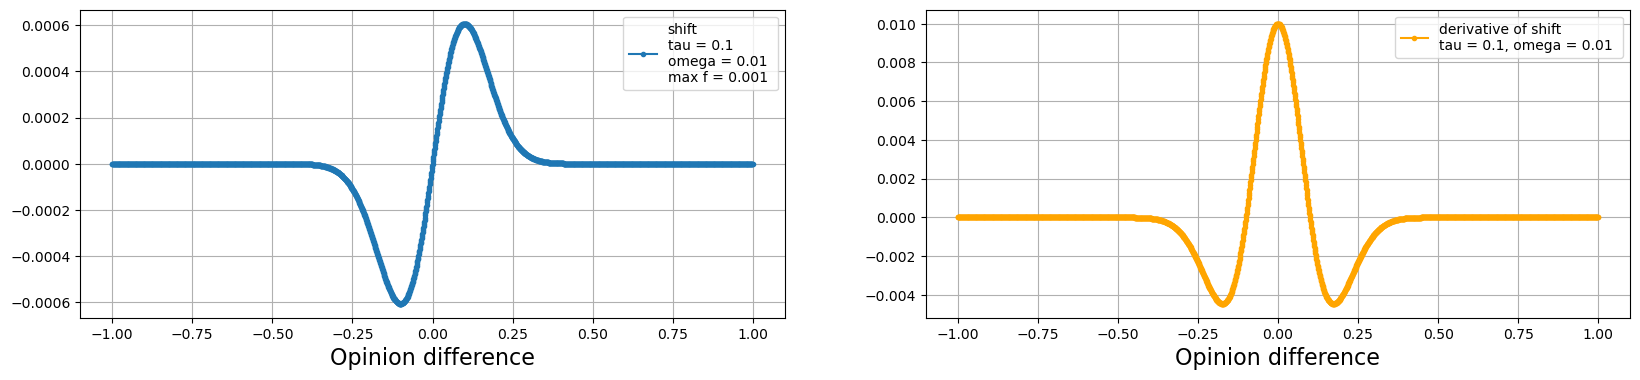

In [2]:
#opinion dynamics info
omega = .01 # strength of persuasion
tau = .1 # confidence interval, easiness to pursuade



x = np.arange(-1,1,.001)
shift_max = np.max(shift(x,tau,omega))


#plot the shift function to see how it looks
plt.figure(figsize =(20,4))
plt.subplot(1,2,1)
plt.plot(x,shift(x,tau,omega),label = f'shift\ntau = {tau}\nomega = {omega}\nmax f = {shift_max:.3f} ',marker='.')
plt.legend()
plt.xlabel('Opinion difference',fontsize = 16)
plt.grid()

plt.subplot(1,2,2)
plt.plot(x,dshift(x,tau,omega),label = f'derivative of shift\ntau = {tau}, omega = {omega} ',color = 'orange',marker='.')
plt.legend()
plt.xlabel('Opinion difference',fontsize = 16)
plt.grid()
plt.show()

# Network Inputs

We create a list `agents_targets_indices` that puts in the index for the nodes for the simulator (the simulator does not use screen names, but numerical indices for the nodes).


In [3]:
#INPUTS
NETWORK_TYPES = ['custom',"erdos_renyi", 'path']
NETWORK_TYPE =NETWORK_TYPES[2]
print(NETWORK_TYPE)
#Network input


if NETWORK_TYPE == "custom":
    #Custom
    G0 = nx.DiGraph()
    G0.add_node("1", opinion=0.5, rate=1)
    G0.add_node("2", opinion=0.75, rate=1)
    #G0.add_node("3", opinion=0.15, rate=1)
    
    #G0.add_edge("2","1")
    G0.add_edge("1","2")
    #G0.add_edge("1","3")
    #G0.add_edge("3","1")
    #G0.add_edge("2","3")
    #G0.add_edge("3","2")
   
elif NETWORK_TYPE == "erdos_renyi":
    G0 = nx.DiGraph()
    nv = 20
    pedge = 0.25
    for i in range(nv):
        rate = 1
        opinion = i/(nv-1) * 1
        G0.add_node(f"{i}", opinion=opinion, rate=rate)

    for i in range(nv):    
        for j in range(i):
            if random.random()<=pedge:
                G0.add_edge(f"{i}",f"{j}")
            if random.random()<=pedge:
                G0.add_edge(f"{j}",f"{i}")

elif NETWORK_TYPE == 'path':
    nv = 100
    G0 = nx.path_graph(nv)  # Creates a path network with 5 nodes
    for i in range(nv):
        rate = 1
        opinion = i/(nv-1) * 1
        G0.add_node(i, opinion=opinion, rate=rate)
                
rates = np.array([G0.nodes[v]["rate"] for v in G0.nodes()])
opinions0 = np.array([G0.nodes[v]["opinion"] for v in G0.nodes()])


#Network parameters: create node_index for simulator
node_index = {}
node_screen_name = list(G0.nodes())
for cnt,v in enumerate(G0.nodes()):
    node_index[v] = cnt





path


Network has 100 nodes, 99 edges


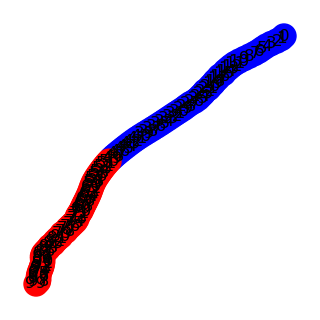

In [4]:
#adjacency matrix of network
A = nx.adjacency_matrix(G0)
A = A.tocoo()
n = A.shape[0]  #number of nodes in network


print(f"Network has {n} nodes, {G0.number_of_edges()} edges")
G = G0.copy()


if n<=100:
    colors = []
    for v in G.nodes():
        #print(f"{v}: {G.nodes[v]}")
        if (G.nodes[v]['opinion']<0.5) & (G.nodes[v]['opinion']>=0):
            colors.append('blue')
        elif (G.nodes[v]['opinion']>0.5) & (G.nodes[v]['opinion']<=1):
            colors.append('red')
        elif G.nodes[v]['opinion']==0.5:
            colors.append('purple')
        else:
            colors.append('green')
    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize = (3,3))
    nx.draw(G,pos, node_color = colors)
    nx.draw_networkx_labels(G,pos)

# Objective and Simulation Parameters

In [33]:
#objective function to be maximized
#OBJECTIVE can be "MEAN", "VAR","VAR_NEG", "MEAN_TAVG","VAR_TAVG","VAR_TAVG_NEG",'MEAN_TAVG'  
#TAVG = time average
OBJECTIVE = 'VAR_NEG'
alpha   = 1.07e-2  #Weight of control strength

# simulation time parameters
tmax = 20000 #tmax = tf = final time for simulation in [time units]
nsteps = 100  #number of discrete steps in the simulation

print(f"Maximize {OBJECTIVE}\nSimulation has {nsteps} steps for t = 0 .. {tmax}")

Maximize VAR_NEG
Simulation has 100 steps for t = 0 .. 20000


# Run Simulation With No Agent

Run the opinion dynamics simulation with no agents.  This let's you see if the time scale and step for the simulation are ok.

Opinion simuator takes 0.796875 seconds
Adjoint simuator takes 4.515625 seconds
No agent VAR_NEG = -0.056591


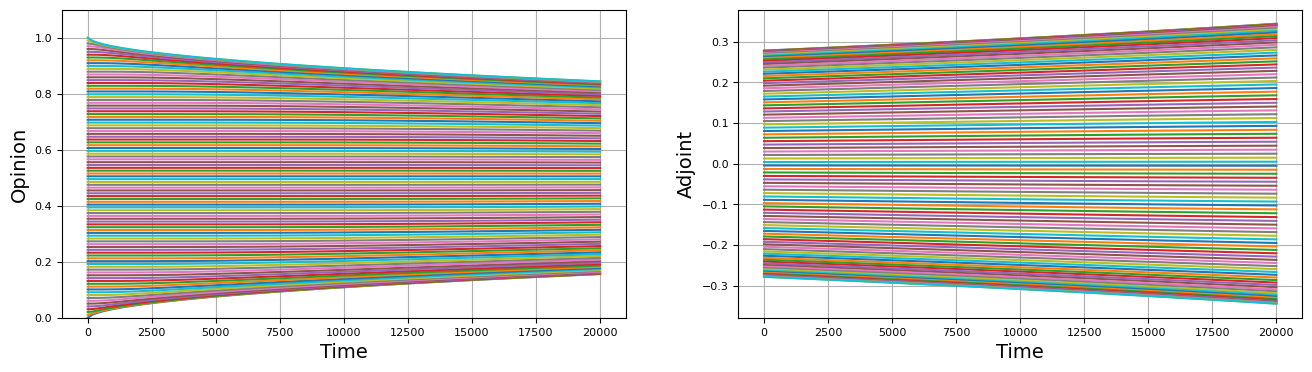

In [34]:
start = time.process_time()
Opinions, T = simulate_opinion(opinions0, rates, A, 
                                nsteps, tmax, tau, omega)
tsim = time.process_time() - start
print(f"Opinion simuator takes {tsim} seconds")

#########################
start = time.process_time()
pf = boundary_condition_Pf(OBJECTIVE, Opinions)

P, T = simulate_adjoint(pf, Opinions, rates, A, 
                        nsteps, tmax, tau, omega, OBJECTIVE)

tsim = time.process_time() - start
print(f"Adjoint simuator takes {tsim} seconds")
obj_no_agent = objective_value(OBJECTIVE, Opinions)
print(f"No agent {OBJECTIVE} = {obj_no_agent:.6f}")


Opinions_no_agent  = Opinions
P_no_agent  = P
################################################
plt.figure(figsize = (16,4))
plot_opinion_adjoint(T,Opinions_no_agent, P_no_agent)


# Run Simulation with Optimal Agent (Using Pre-Computed Adjoints)

Opinion simuator takes 5.0625 seconds
Adjoint simuator takes 0.484375 seconds
Agent VAR_NEG = -0.000000


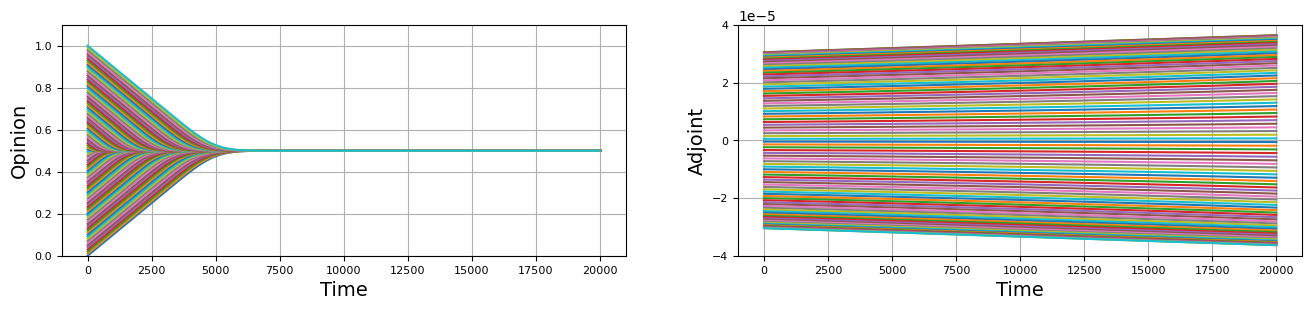

In [35]:
PLOT = True
start = time.process_time()
Opinions, T = simulate_opinion_opt(opinions0, rates, A, 
                                    nsteps, tmax, tau, omega,
                                    P, alpha)


tsim = time.process_time() - start
print(f"Opinion simuator takes {tsim} seconds")

###################################################
start = time.process_time()
pf = boundary_condition_Pf(OBJECTIVE, Opinions)

P, T = simulate_adjoint(pf, Opinions, rates, A, 
                        nsteps, tmax, tau, omega, 
                        OBJECTIVE)

tsim = time.process_time() - start
print(f"Adjoint simuator takes {tsim} seconds")
obj = objective_value(OBJECTIVE, Opinions)
print(f"Agent {OBJECTIVE} = {obj:.6f}")


if PLOT:
    plt.figure(figsize = (16,3))
    plot_opinion_adjoint(T,Opinions,P)

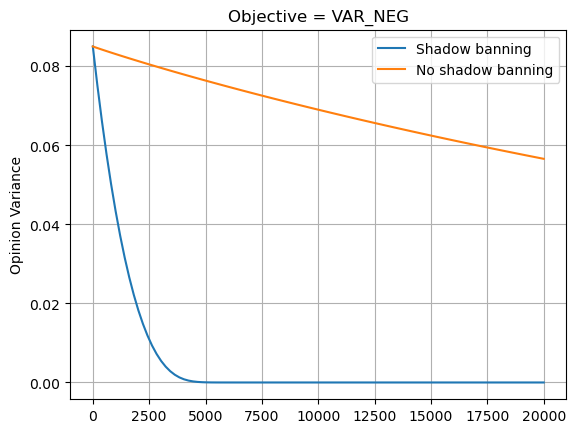

In [36]:
#Plot instantaneous mean with and without shadowbanning
if OBJECTIVE =="MEAN":
    plt.plot(T,np.mean(Opinions, axis = 1), label = 'Shadow banning')
    plt.plot(T,np.mean(Opinions_no_agent, axis = 1), label = 'No shadow banning')
    plt.ylabel("Opinion Mean")
elif "VAR" in OBJECTIVE:
    plt.plot(T,np.var(Opinions, axis = 1), label = 'Shadow banning')
    plt.plot(T,np.var(Opinions_no_agent, axis = 1), label = 'No shadow banning')
    plt.ylabel("Opinion Variance")
plt.title(f"Objective = {OBJECTIVE}")
plt.grid()   
plt.legend()
plt.show()


# Run Simulation Method of Multipliers

Iteration 0: VAR_NEG = -0.056591


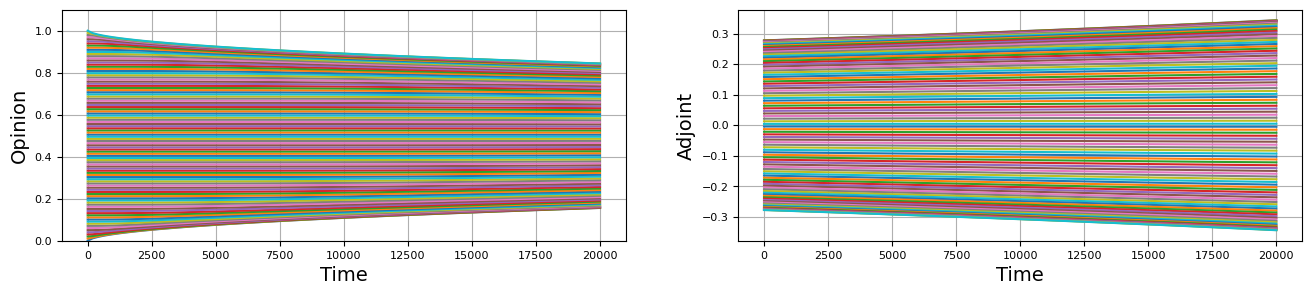

Iteration 1: VAR_NEG = -0.000000


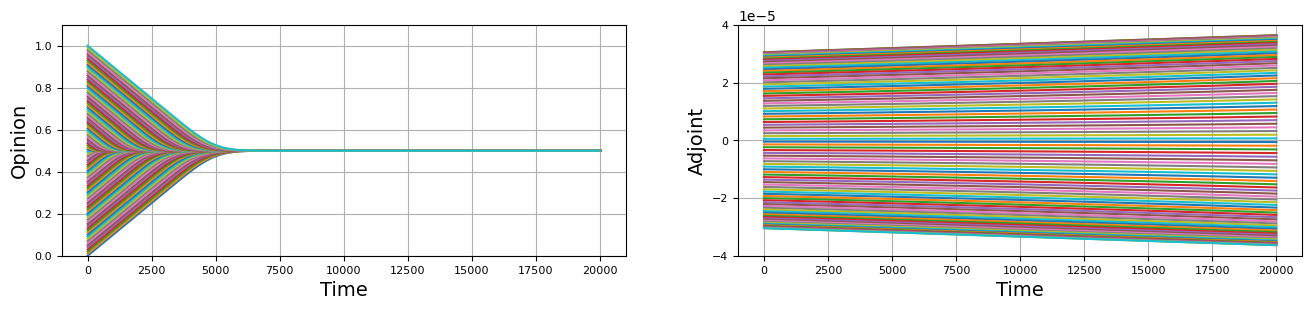

Iteration 2: VAR_NEG = -0.052671


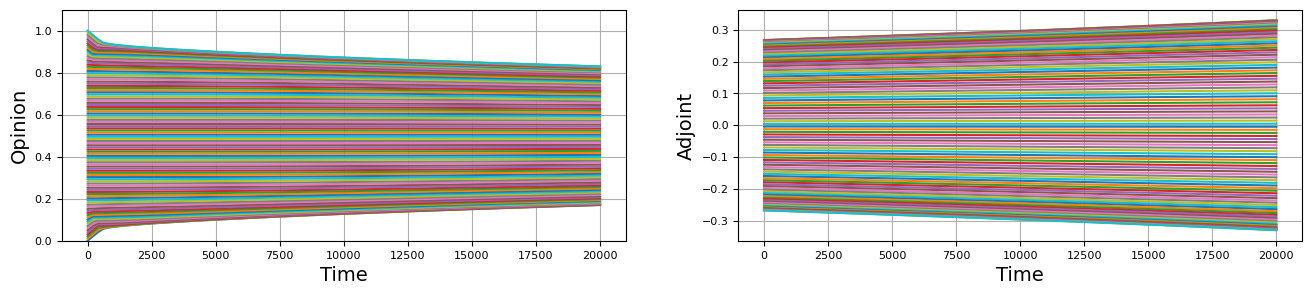

In [42]:
PLOT = True
max_iter = 3
obj_best = -float('inf')
Obj = []

for c in range(max_iter):
    if c ==0:
        Opinions, T = simulate_opinion(opinions0, rates, A, 
                                        nsteps, tmax, tau, omega)
    else:        
        Opinions, T = simulate_opinion_opt(opinions0, rates, A, 
                                        nsteps, tmax, tau, omega,
                                        P, alpha)


    obj = objective_value(OBJECTIVE,Opinions)
    print(f"Iteration {c}: {OBJECTIVE} = {obj:.6f}")    

    pf = boundary_condition_Pf(OBJECTIVE, Opinions)

    P, T = simulate_adjoint(pf, Opinions, rates, A, 
                        nsteps, tmax, tau, omega, OBJECTIVE)
    if PLOT:
        plt.figure(figsize = (16,3))
        plot_opinion_adjoint(T,Opinions, P)
        plt.show()
    #####################
    change = np.abs(obj_best-obj)
    Obj.append(obj)
    if obj > obj_best:
        obj_best = obj
        Tbest, Opinions_best, Pbest = T, Opinions, P
    c+=1

        
        


# Optimal Shadow Ban Analysis

## Plot Objective vs Iteration of MM Algorithm

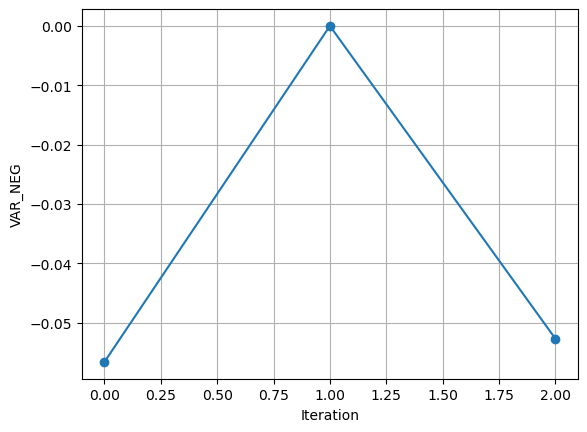

In [43]:
plt.plot(Obj,marker  ='o')
plt.ylabel(f"{OBJECTIVE}")
plt.xlabel("Iteration")
plt.grid()

## Plot Optimal Opinions and Adjoints vs Time

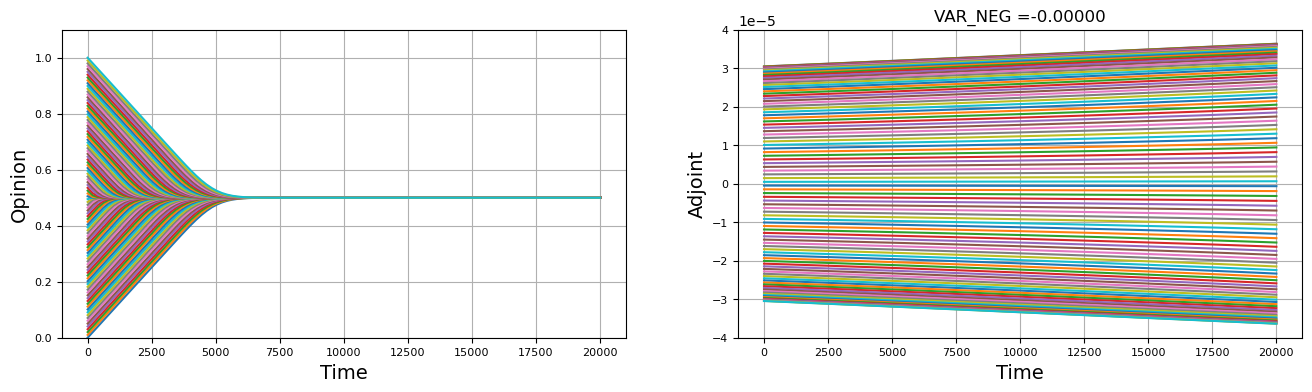

In [44]:
plt.figure(figsize = (16,4))
plot_opinion_adjoint(Tbest,Opinions_best, Pbest)
plt.title(f"{OBJECTIVE} ={obj_best:.5f}")
plt.show()



## Plot Quantiles and Heatmap of No Shadow Ban and Optimal Shadow Ban Opinions

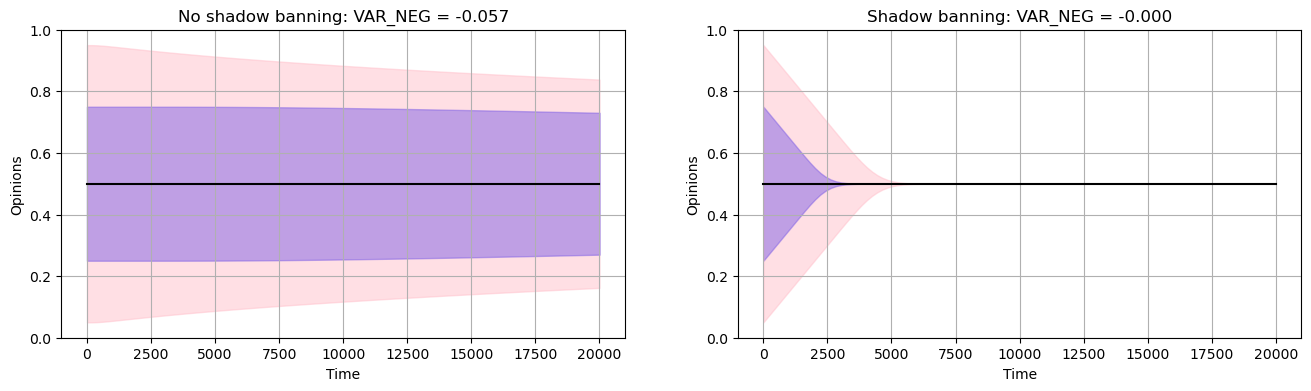

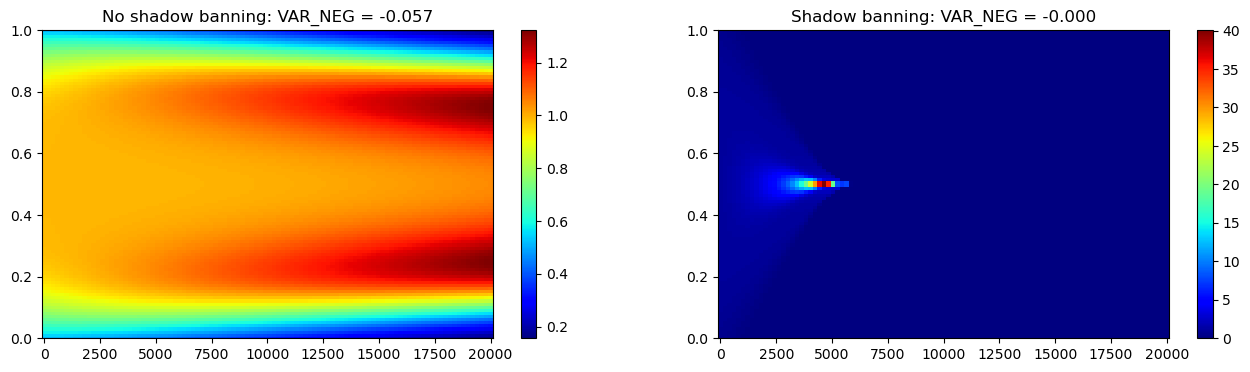

In [45]:
#plot opinion quantiles
plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
plot_opinion_quantiles(T, Opinions_no_agent)
plt.title(f"No shadow banning: {OBJECTIVE} = {obj_no_agent:.3f}")
plt.ylim([0,1])

plt.subplot(1,2,2)
plot_opinion_quantiles(T,Opinions_best)
plt.title(f"Shadow banning: {OBJECTIVE} = {obj_best:.3f}")
plt.ylim([0,1])
plt.show()

##########################
#plot opinion heatmap
plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
plot_opinion_heatmap(T, Opinions_no_agent,'jet')
plt.title(f"No shadow banning: {OBJECTIVE} = {obj_no_agent:.3f}")
plt.ylim([0,1])

plt.subplot(1,2,2)
plot_opinion_heatmap(T,Opinions_best, 'jet')
plt.title(f"Shadow banning: {OBJECTIVE} = {obj_best:.3f}")
plt.ylim([0,1])

plt.show()

## Plot Optimal Shadow Ban Strenght vs Time

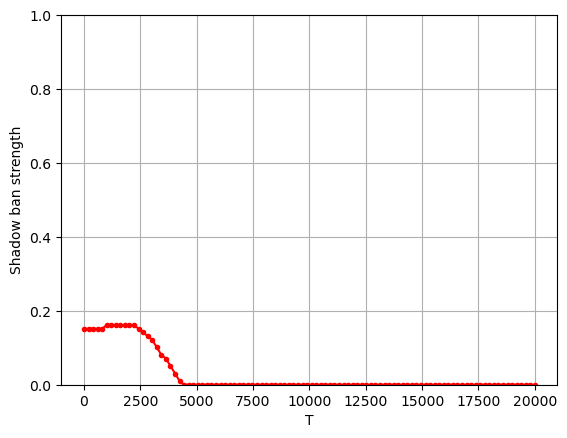

In [46]:
Opinions = Opinions_best
P = Pbest

Shadowban_strength = []
for tind in range(len(T)):
    opinions = Opinions[tind,:]
    ps = P[tind,:]
    Ustar = shadowban_opt(opinions, ps, rates, A, tau, omega, alpha, tmax)
    if len(Ustar.data) >0:
        shadowban_strength = 1-np.mean(Ustar.data)
    else:
        shadowban_strength = 0
    Shadowban_strength.append(shadowban_strength)
Shadowban_strength = np.array(Shadowban_strength )

plt.plot(T,Shadowban_strength, marker = '.', color = 'red')
plt.grid()
plt.xlabel('T')
plt.ylabel("Shadow ban strength")
plt.ylim([0,1])
plt.show()
